# Understanding VQE and Quantum Chemistry with Qiskit-Nature
## 1. What is VQE (Variational Quantum Eigensolver)?
The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm designed to find the ground state energy of chemical and physical systems. It's especially valuable for NISQ (Noisy Intermediate-Scale Quantum) era hardware due to its resilience to certain types of quantum noise.
Key components of VQE:

**Quantum Circuit** : A parameterized quantum circuit (ansatz) that prepares a trial state
Hamiltonian Operator: Represents the system whose ground state we're finding
Classical Optimizer: Updates the circuit parameters to minimize energy

#### VQE works by iteratively:

Preparing a quantum state using a parameterized circuit
Measuring the energy (expectation value of the Hamiltonian)
Using classical optimization to update parameters and reduce energy
Repeating until convergence

## 2. Quantum Chemistry Basics for VQE
Quantum chemistry applies quantum mechanics to understand chemical systems. For quantum computing applications:

**Electronic Structure Problem**: Find the ground state energy of a molecule by solving the electronic Schrödinger equation
Second Quantization: Representation of quantum states using creation and annihilation operators
Qubit Mapping: Converting fermionic (electron) operators to qubit operators through mappings like Jordan-Wigner, Parity, or Bravyi-Kitaev

## 3. Implementing VQE with Qiskit-Nature: H₂ Molecule Example
Let's implement a practical example to find the ground state energy of a hydrogen molecule (H₂) using Qiskit-Nature.

In [1]:
# Import required packages
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import Estimator

# Step 1: Set up the molecular system using PySCF driver
driver = PySCFDriver(
    atom='H 0 0 0; H 0 0 0.735',  # H₂ molecule with 0.735 Angstrom bond length
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g',  # Using STO-3G basis set
)
problem = driver.run()

# Step 2: Set up the qubit mapper
# We use ParityMapper which can reduce qubits due to symmetries
mapper = ParityMapper(num_particles=problem.num_particles)

# Step 3: Set up the classical optimizer
optimizer = L_BFGS_B()

# Step 4: Set up the quantum estimator primitive
estimator = Estimator()

# Step 5: Set up the VQE ansatz
# UCCSD (Unitary Coupled Cluster Singles and Doubles) with Hartree-Fock initial state
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

# Step 6: Set up the VQE algorithm
vqe = VQE(estimator, ansatz, optimizer)
# Ensure optimizer starts from Hartree-Fock state (all zeros)
vqe.initial_point = [0] * ansatz.num_parameters

# Step 7: Create and run the ground state solver
algorithm = GroundStateEigensolver(mapper, vqe)
result = algorithm.solve(problem)

# Step 8: Print the results
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948705399]
    - computed part:      [0.0  0.0  1.388948705399]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000005399]  Total: 0.000000005399
                 (debye): [0.0  0.0  -0.000000013722]  Total: 0.000000013722
 


/var/folders/kd/rt2jnyms2gsb83pg205v_z1c0000gn/T/ipykernel_25463/1495460854.py:27: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


## 4. Understanding the Components

### 4.1 PySCFDriver
- Creates the molecular specification (H₂ in this case)
- Computes one and two-body integrals required for the Hamiltonian
- Returns an `ElectronicStructureProblem` containing all the needed problem information

### 4.2 ParityMapper
- Converts fermionic operators to qubit operators
- Reduces the number of qubits by exploiting symmetries when provided with the number of particles
- This is particularly advantageous for NISQ devices with limited qubits

### 4.3 UCCSD Ansatz
- Unitary Coupled Cluster Singles and Doubles
- Chemistry-inspired ansatz that works well for molecular systems
- Starts from the Hartree-Fock state (classical approximation)
- Creates entanglement through single and double excitation operators

### 4.4 VQE Configuration
- Uses the Estimator primitive for quantum computations 
- The L_BFGS_B optimizer is efficient for ground state energy calculations
- Setting initial_point to all zeros ensures starting from the Hartree-Fock state

## 5. Analyzing the Results

The output provides:
- Electronic ground state energy (Hartree)
- Nuclear repulsion energy
- Total ground state energy
- Other observables like number of particles and spin

For H₂ with a bond length of 0.735 Å using STO-3G basis, the expected energy should be approximately -1.14 Hartrees.

## 6. Advanced Applications: Potential Energy Surface

To study molecular properties more comprehensively, you can calculate the potential energy surface by varying the bond distance:

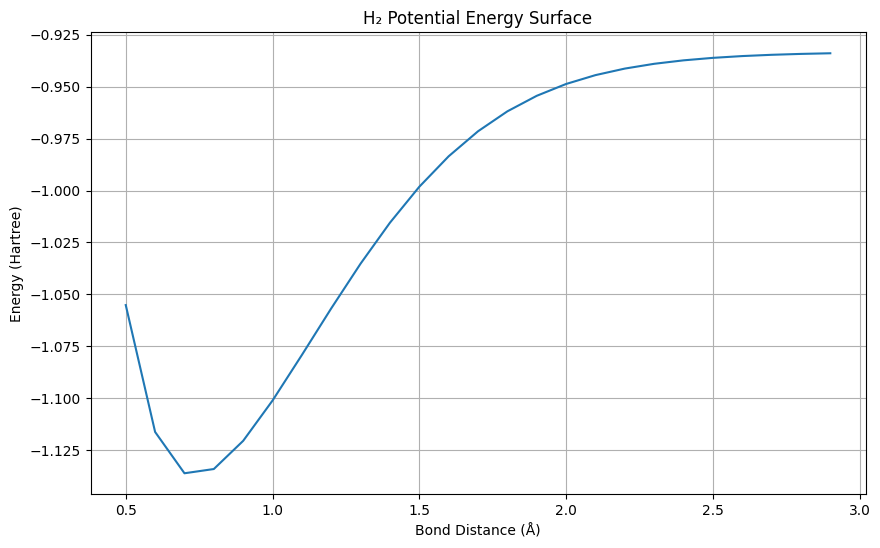

In [3]:
import numpy as np
import matplotlib.pyplot as plt

distances = np.arange(0.5, 3.0, 0.1)  # Bond distances in Angstroms
energies = []

for distance in distances:
    # Recalculate for each bond distance
    driver = PySCFDriver(
        atom=f'H 0 0 0; H 0 0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        basis='sto3g',
    )
    # Run calculation as before
    problem = driver.run()
    result = algorithm.solve(problem)
    energies.append(result.total_energies)

# Plot the potential energy surface
plt.figure(figsize=(10, 6))
plt.plot(distances, energies)
plt.xlabel('Bond Distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('H₂ Potential Energy Surface')
plt.grid(True)
plt.show()

## 7. Key Considerations and Tips

1. **Basis Sets**: Larger basis sets (beyond STO-3G) provide more accurate results but require more qubits

2. **Qubit Reduction**: Different mappers offer various qubit reduction techniques
   - ParityMapper (used here) can remove 2 qubits
   - JordanWignerMapper is more straightforward but uses more qubits
   - BravyiKitaevMapper offers a middle ground in terms of locality and qubit count

3. **Ansatz Selection**:
   - UCCSD works well for chemistry but has many parameters
   - For NISQ devices, consider EfficientSU2 with appropriate entanglement patterns

4. **Optimizer Tuning**:
   - For noise-free simulators, L_BFGS_B works well
   - For real quantum hardware, consider SPSA or COBYLA which are more noise-resistant

5. **Error Mitigation**:
   - Consider using Qiskit's error mitigation techniques when running on real hardware
   - Readout error mitigation and zero-noise extrapolation can significantly improve results

## 8. Extensions to Other Molecules

This framework can be extended to more complex molecules by modifying the driver configuration:

```python
# Example for water (H₂O)
driver = PySCFDriver(
    atom='O 0 0 0; H 0 0.757 0.586; H 0 -0.757 0.586',
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g',
)
```

For larger molecules, consider:
- Using symmetries to reduce computational requirements
- Active space approximations to focus on the most relevant orbitals
- Frozen core approximations to reduce the number of qubits

## Conclusion

VQE implemented through Qiskit-Nature offers a powerful approach to quantum chemistry problems. By leveraging hybrid quantum-classical computation, it allows us to study molecular systems even on today's NISQ devices. As quantum hardware advances, this approach can be extended to increasingly complex molecules beyond the reach of classical computation.
